In [1]:
# work environment: jl2815
import pandas as pd
import numpy as np
import pickle
import os
import sys

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormap module  # Create a colormap (e.g., 'viridis' or 'plasma')

from skgstat import Variogram
from scipy.spatial.distance import pdist, squareform

from typing import Callable   # nearest neighbor function input type
import sklearn.neighbors  # nearest neighbor
from sklearn.neighbors import BallTree # for space_center function
 
from GEMS_TCO import orbitmap
# from GEMS_TCO.smoothspace import space_average

In [2]:
output_dir = r"C:\\Users\\joonw\\TCO\\pipeline_2025\\outputs" # r raw string
os.makedirs(output_dir, exist_ok=True)                        # no error if directory already exist
os.chdir(output_dir)
print(os.getcwd())

C:\Users\joonw\TCO\pipeline_2025\outputs


# Investigate Spatial Stationarity

Given ```Longitude E110 to E120, Latitude N5 to N10```, create two hash maps for                                
```(West: Longitude E110 to E115, East: Longitude Longitude E115 to E120)```      
and then another two maps for                           
```(North:Latitude N5 to N7.5, South:Latitude N7.5 to N10)```.      

# Summary

Both plots on January 2023, and July 2024 shows that the GEMS ozone process is anisotropic and this has to be reflected in modeling.

### Create and save plots of semivariograms and variances from January 2023 to December 2024.

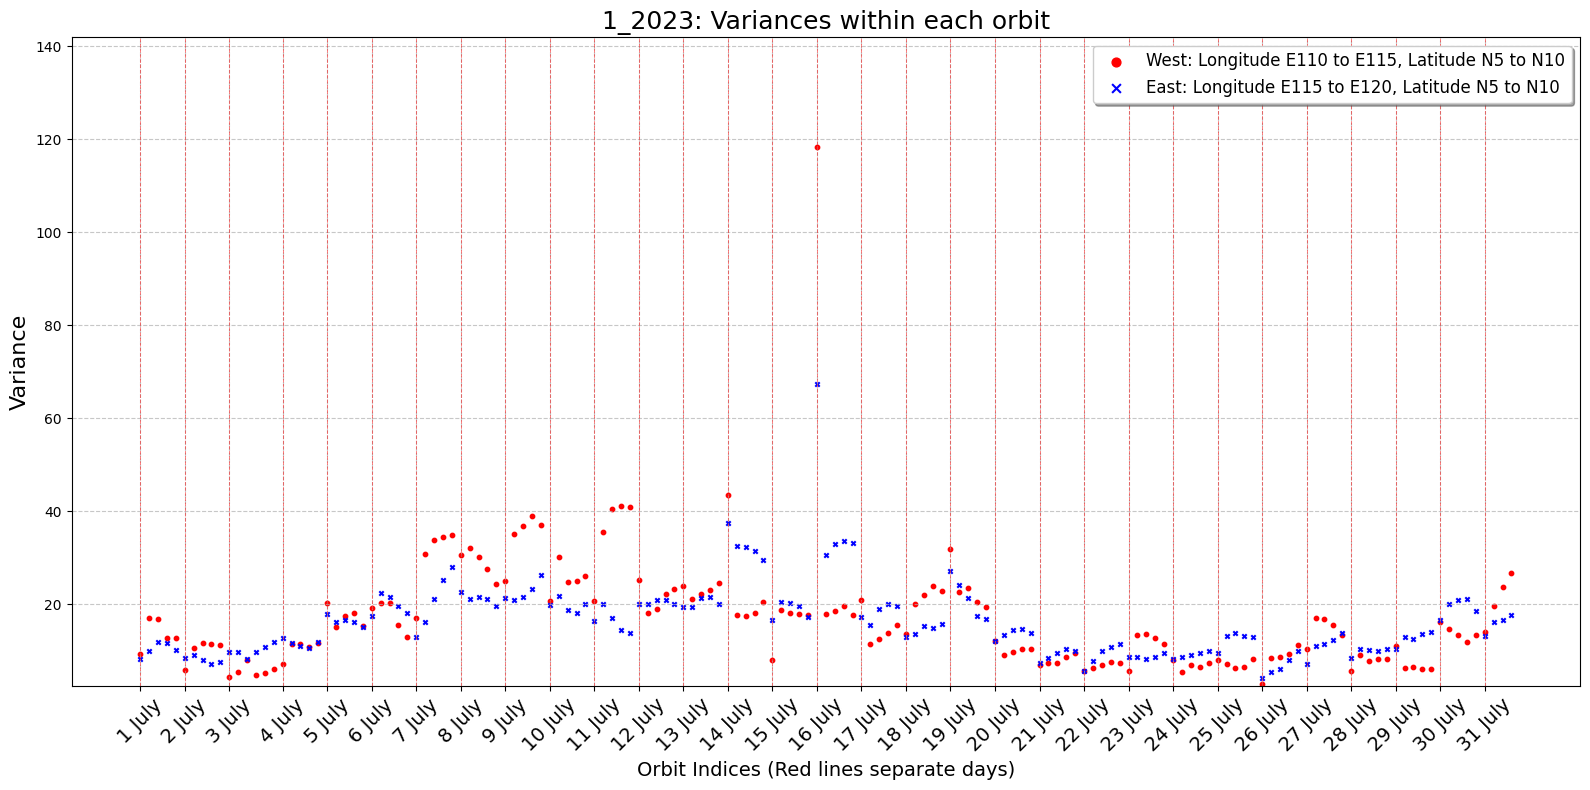

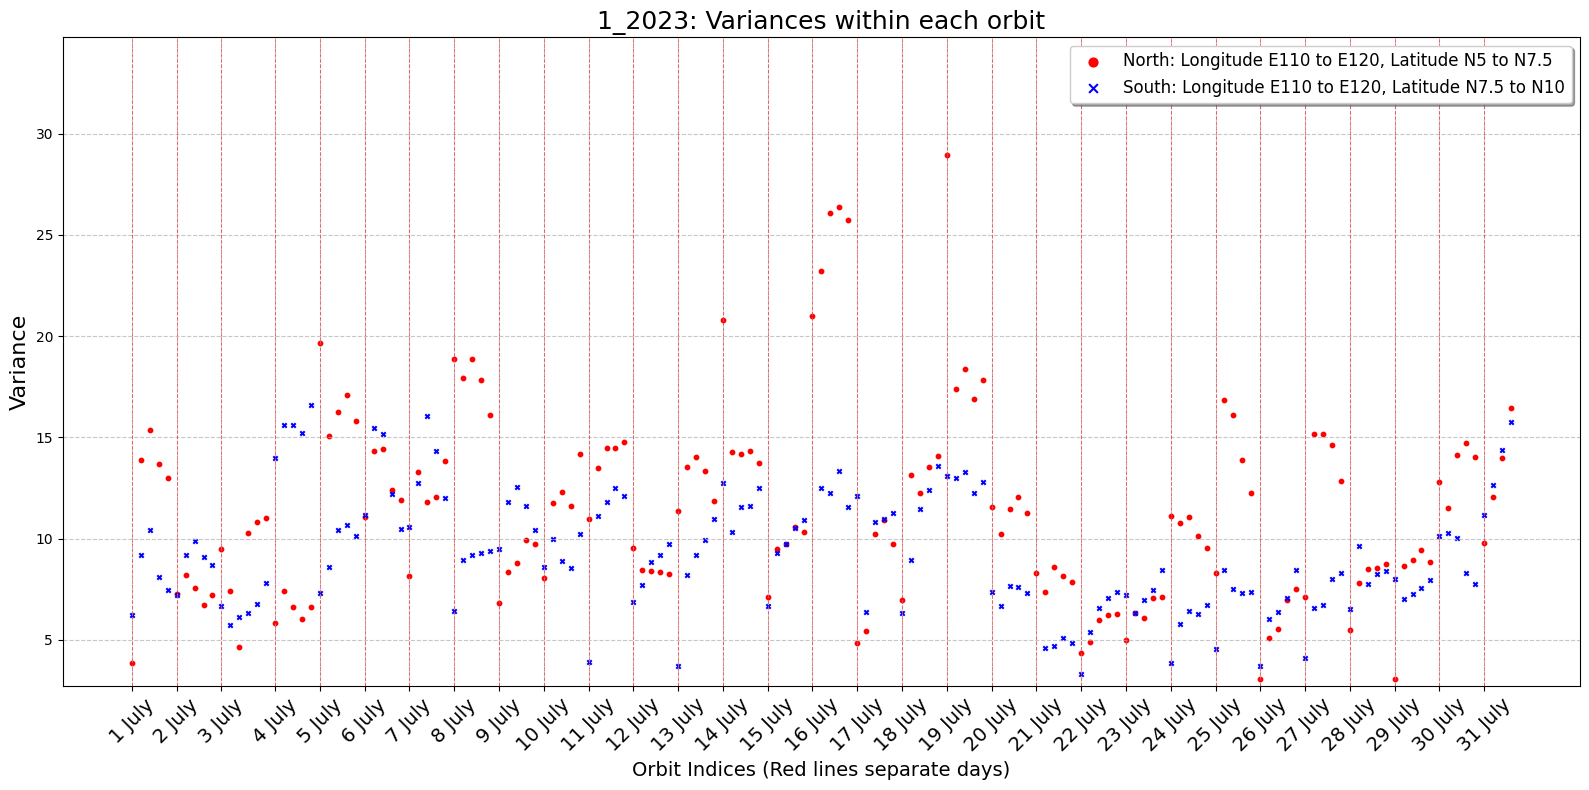

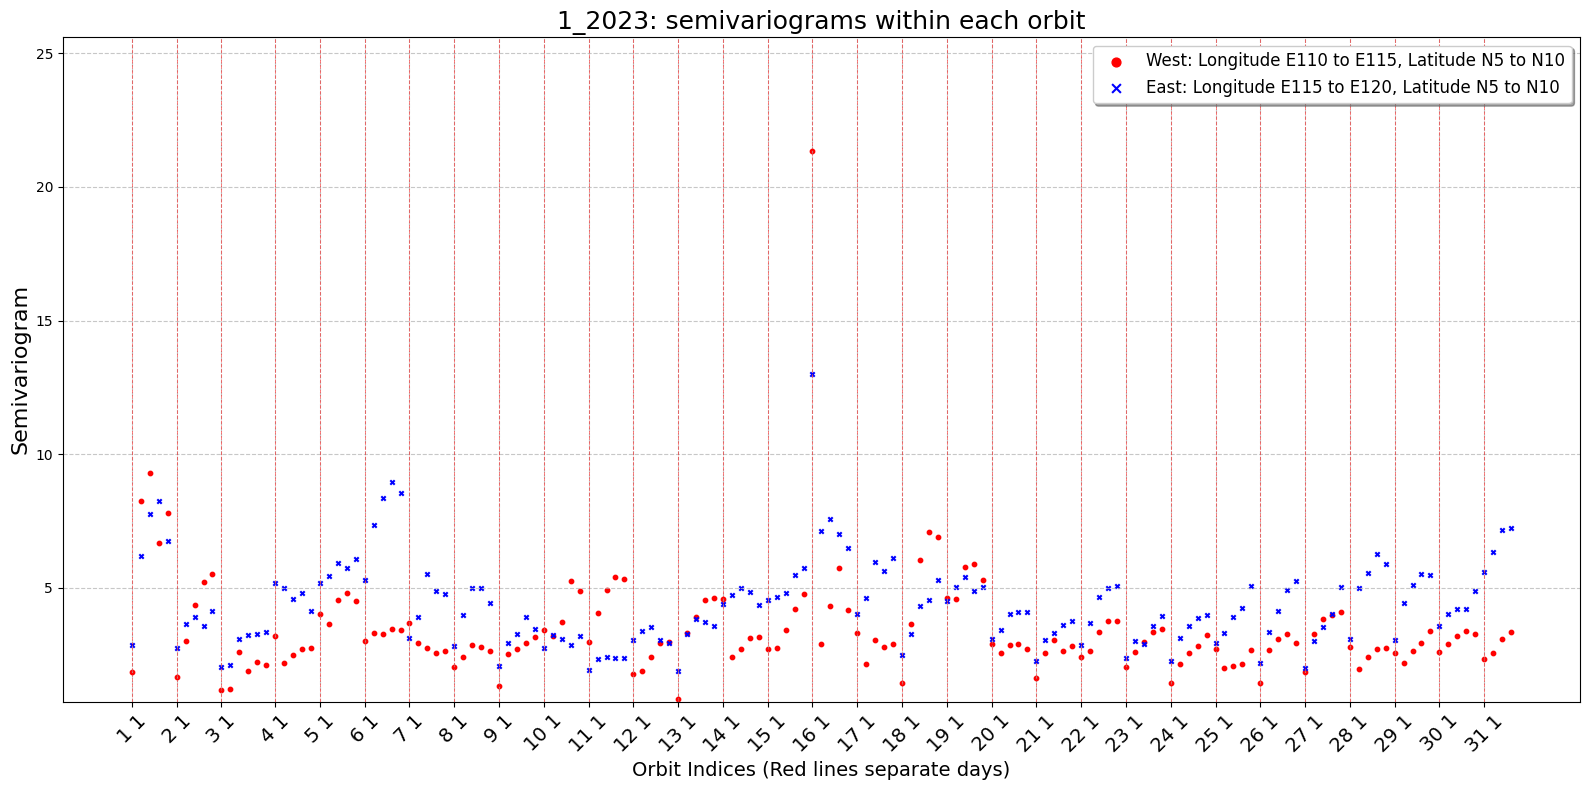

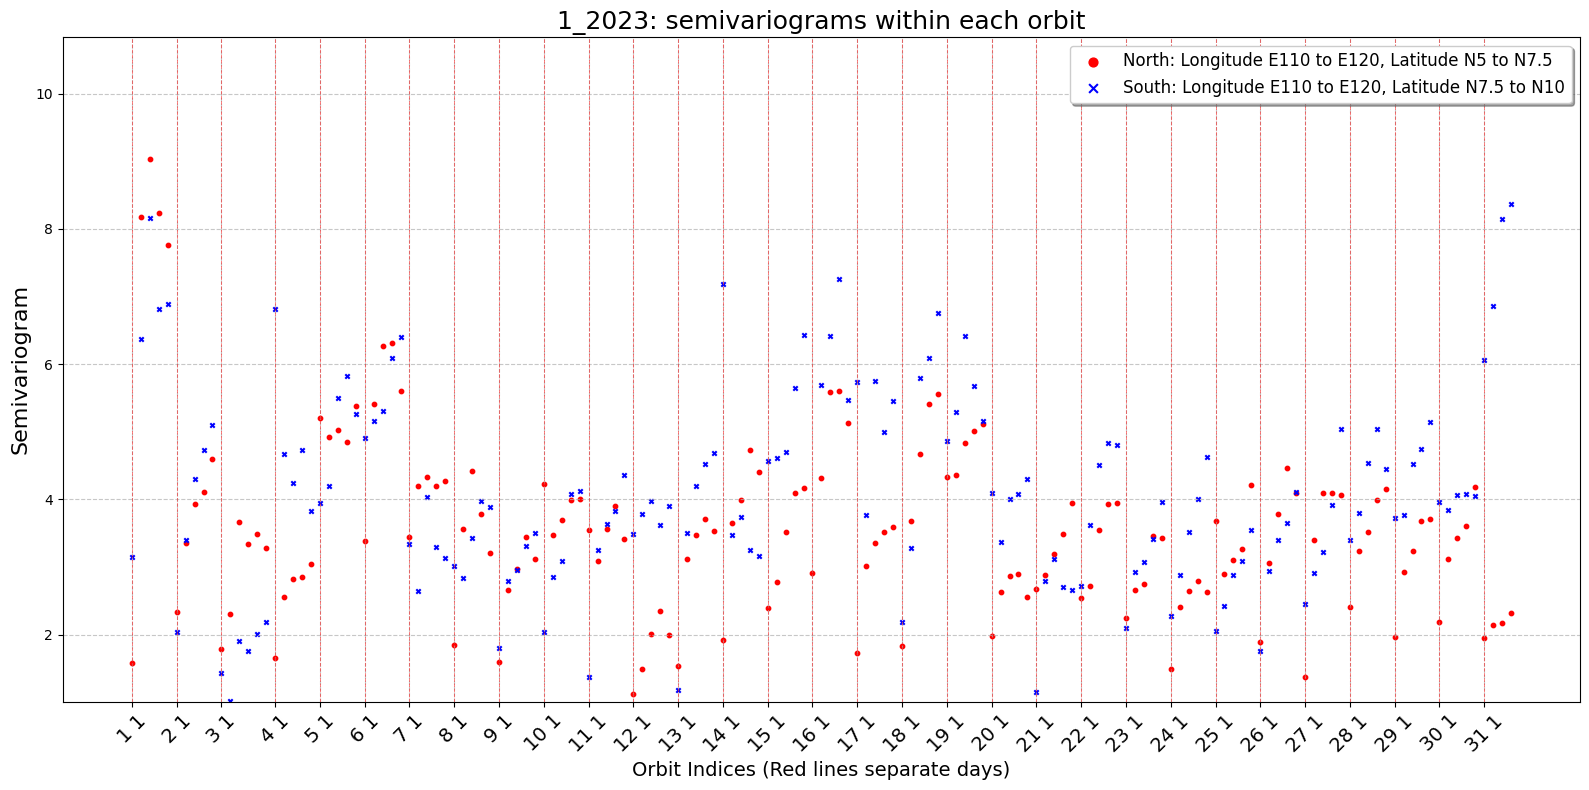

In [ ]:
for year in ['2023']:
    for month in range(1,2):
        filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
        
        ''' 
        loaded_map should be a hash map that returns dataframe for 'year' and 'month'.
        '''

        instance_t = timeseries(loaded_map, year, month, output_dir)
        instance_t.save_data_plots()

We can expand to other months using loop below.

In [ ]:
for year in ['2023','2024']:
    for month in range(1,13):
        filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
        
        ''' 
        loaded_map should be a hash map that returns dataframe for 'year' and 'month'.
        '''

        instance_t = timeseries(loaded_map, year, month, output_dir)
        instance_t.save_data_plots()

In [3]:
class timeseries:
    def __init__(self, map: dict, year: str, month: int, output_dir: str):
        self.map = map
        self.year = year
        self.month = month
        self.output_dir = output_dir

    def var_timeseries_month(self):
        var_timeseries = []

        # Generate variance and month markers
        for _, key in enumerate(self.map.keys()):
            cur = self.map[key]
            var_timeseries.append(np.var(cur['ColumnAmountO3']))

        return var_timeseries
     
    def sem_timeseries_month(self, sem_lag=0.2, tolerance=0.02):

        sem_timeseries = []
        sem_lag = 0.2
        tolerance = 0.02

        # Generate semivariograms and day markers
        for _, key in enumerate(self.map.keys()):
            cur = self.map[key]
            coordinates = np.array(cur[['Latitude', 'Longitude']])
            values = np.array(cur['ColumnAmountO3'])
            pairwise_distances = squareform(pdist(coordinates))
            valid_pairs = np.where((pairwise_distances >= sem_lag - tolerance) &
                                    (pairwise_distances <= sem_lag + tolerance))

            if len(valid_pairs[0]) == 0:
                sem_timeseries.append(np.nan)
                continue
            
            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)
            sem_timeseries.append(semivariances)

        return sem_timeseries
    
    def map_separation(self):
        '''  
        this method creates 4 maps: West, East, North and South. 
        In this method, I clipped data ozone values between 150 and 300. 
        '''
        coarse_dict = {}
        for key in self.map:
            cur = self.map[key].copy()

            ## we need to remove outliars
            mask = (cur['ColumnAmountO3'] < 150) | (cur['ColumnAmountO3'] > 300)
            filtered_data = cur[~mask].reset_index(drop=True)

            # Handle cases where the filtered DataFrame is empty
            if filtered_data.empty:
                print(f"Warning: No valid data for key {key}. Skipping.")
                continue
            coarse_dict[key] = filtered_data

        coarse_map_left = {}
        coarse_map_right = {}
        coarse_map_north = {}
        coarse_map_south = {}

        keys = sorted(coarse_dict.keys())
        lat_s, lat_e, lon_s, lon_e = 5, 10, 110, 120
        mid_lon = np.mean([lon_s, lon_e])
        mid_lat = np.mean([lat_s, lat_e])

        
        for key in keys:
            data = coarse_dict[key]
            coarse_map_left[key] = data[data['Longitude'] <= mid_lon]
            coarse_map_right[key] = data[data['Longitude'] > mid_lon]
            coarse_map_north[key] = data[data['Latitude'] > mid_lat]
            coarse_map_south[key] = data[data['Latitude'] <= mid_lat]

        self.coarse_dict = coarse_dict

        return coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south

    def compute_sem_var(self):
        """
        Compute variances and semivariograms for spatially divided submaps.
        Most of the computation time will be spent here.
        """
        coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south = self.map_separation()
        coarse_maps = [coarse_map_left,coarse_map_right,coarse_map_north,coarse_map_south]
        sem_results=[]
        var_results = []

        for submap in coarse_maps:
            if not submap:  # Skip if submap is empty
                print(f"Warning: submap is empty. Skipping.")
                continue
            instance_s = timeseries(submap,self.year, self.month, self.output_dir)
            sem_results.append( list(instance_s.sem_timeseries_month(sem_lag=0.2, tolerance=0.02)))
            var_results.append(list(instance_s.var_timeseries_month()))

        return sem_results, var_results
    
    def save_data_plots(self):

        sem_results, var_results = self.compute_sem_var()

        sem1,sem2,sem3,sem4 = sem_results[0],sem_results[1],sem_results[2],sem_results[3]
        var1,var2,var3,var4 = var_results[0],var_results[1],var_results[2],var_results[3]

        var_sem_map = {}
        var_sem_map[f'{year}_{month}'] = pd.DataFrame({
            'west_sem': sem1, 
            'east_sem': sem2, 
            'north_sem': sem3, 
            'south_sem': sem4,
            'west_var': var1, 
            'east_var': var2, 
            'north_var': var3, 
            'south_var': var4,
        })

        ##### Save the dictionary to a pickle file
        filepath = os.path.join(self.output_dir,'var_sem_map.pkl')
        with open(filepath, 'wb') as pickle_file:
            pickle.dump(var_sem_map, pickle_file)

        ##### Save plots
        
        var_timeseries = []
        day_positions = [0]
        d_labels = ['1']
        prev_day = '01'

        # Generate variance and month markers
        for idx, key in enumerate(self.coarse_dict.keys()):
            cur = self.coarse_dict[key]
            var_timeseries.append(np.var(cur['ColumnAmountO3']))
            current_day = key[9:11]
            if current_day != prev_day:
                day_positions.append(idx)
                d_labels.append(f"{int(current_day)}")  
                prev_day = current_day

        # Generate orbit indices
        orbit_indices = range(len(var_timeseries))

        #### plot 1
        plot_file = os.path.join(self.output_dir, f"West_vs_East_variance_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, var1, marker='o', s=10, color='red', label="West: Longitude E110 to E115, Latitude N5 to N10")
        plt.scatter(orbit_indices, var2, marker='x', s=10, color='blue', label="East: Longitude E115 to E120, Latitude N5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {'July'}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Variance', fontsize=16)
        plt.title(f'{self.month}_{self.year}: Variances within each orbit', fontsize=18)
        plt.ylim([min(var1)*0.9, max(var1) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        #### plot 2
        # Save the plot as an image
        plot_file = os.path.join(self.output_dir, f"North_vs_South_variance_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, var3, marker='o', s=10, color='red', label="North: Longitude E110 to E120, Latitude N5 to N7.5")
        plt.scatter(orbit_indices, var4, marker='x', s=10, color='blue', label="South: Longitude E110 to E120, Latitude N7.5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
        # Add X-ticks for days
        day_labels = [f"{label} {'July'}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Variance', fontsize=16)
        plt.title(f'{self.month}_{self.year}: Variances within each orbit', fontsize=18)
        plt.ylim([min(var3)*0.9, max(var3) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        ###############################################
        ###############################################

        #  Semivariograms
        #### plot 3
        plot_file = os.path.join(self.output_dir, f"West_vs_East_semivariogram_{self.year}_{self.month}.png")

        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, sem1, marker='o', s=10, color='red', label="West: Longitude E110 to E115, Latitude N5 to N10")
        plt.scatter(orbit_indices, sem2, marker='x', s=10, color='blue', label="East: Longitude E115 to E120, Latitude N5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {self.month}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Semivariogram', fontsize=16)
        plt.title(f'{self.month}_{self.year}: semivariograms within each orbit', fontsize=18)
        plt.ylim([min(sem1)*0.9, max(sem1) * 1.2])
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()

        #### plot 4
        plot_file = os.path.join(self.output_dir, f"North_vs_South_semivariogram_{self.year}_{self.month}.png")
        plt.figure(figsize=(16, 8))
        plt.scatter(orbit_indices, sem3, marker='o', s=10, color='red', label="North: Longitude E110 to E120, Latitude N5 to N7.5")
        plt.scatter(orbit_indices, sem4, marker='x', s=10, color='blue', label="South: Longitude E110 to E120, Latitude N7.5 to N10")

        # Add month separation lines
        for pos in day_positions:
            plt.axvline(x=pos, color='red', linestyle='--', linewidth=0.7, alpha=0.5)

        # Add X-ticks for days
        day_labels = [f"{label} {self.month}" for i, label in enumerate(d_labels)]
        plt.xticks(ticks=day_positions, labels=day_labels, fontsize=14, rotation=45)

        # Labels and title
        plt.xlabel('Orbit Indices (Red lines separate days)', fontsize=14)
        plt.ylabel('Semivariogram', fontsize=16)
        plt.title(f'{self.month}_{self.year}: semivariograms within each orbit', fontsize=18)

        # Adjust Y-axis dynamically
        plt.ylim([min(sem3)*0.9, max(sem3) * 1.2])

        # Add grid
        plt.grid(True, linestyle='--', alpha=0.7)

        # Add legend
        plt.legend(fontsize=12, markerscale=2, loc='upper right', frameon=True, shadow=True)
        plt.tight_layout()
        plt.savefig(plot_file)
        plt.show()
        
    

## Let's look at another month of data. 

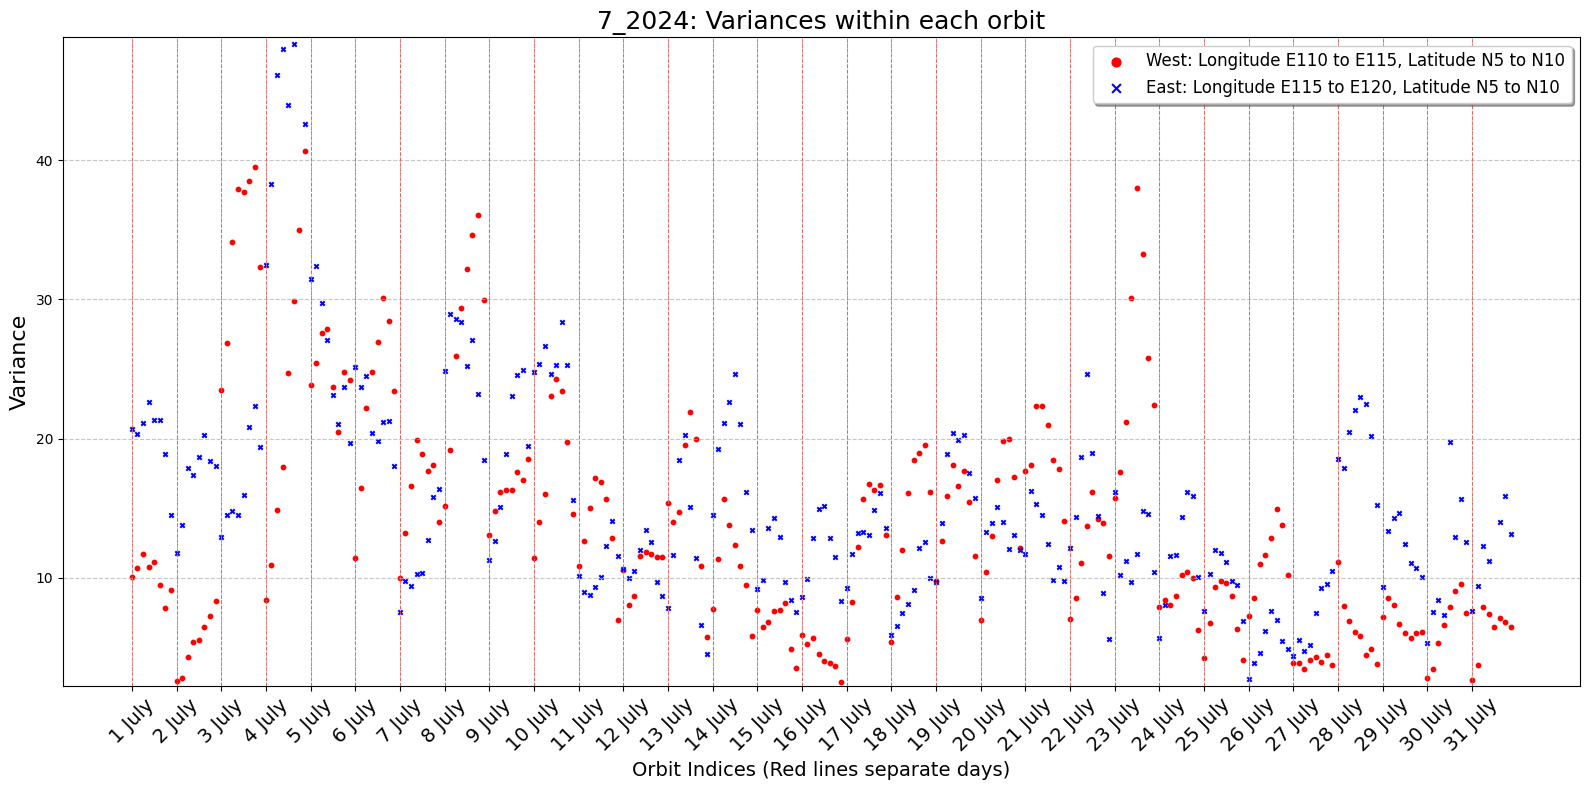

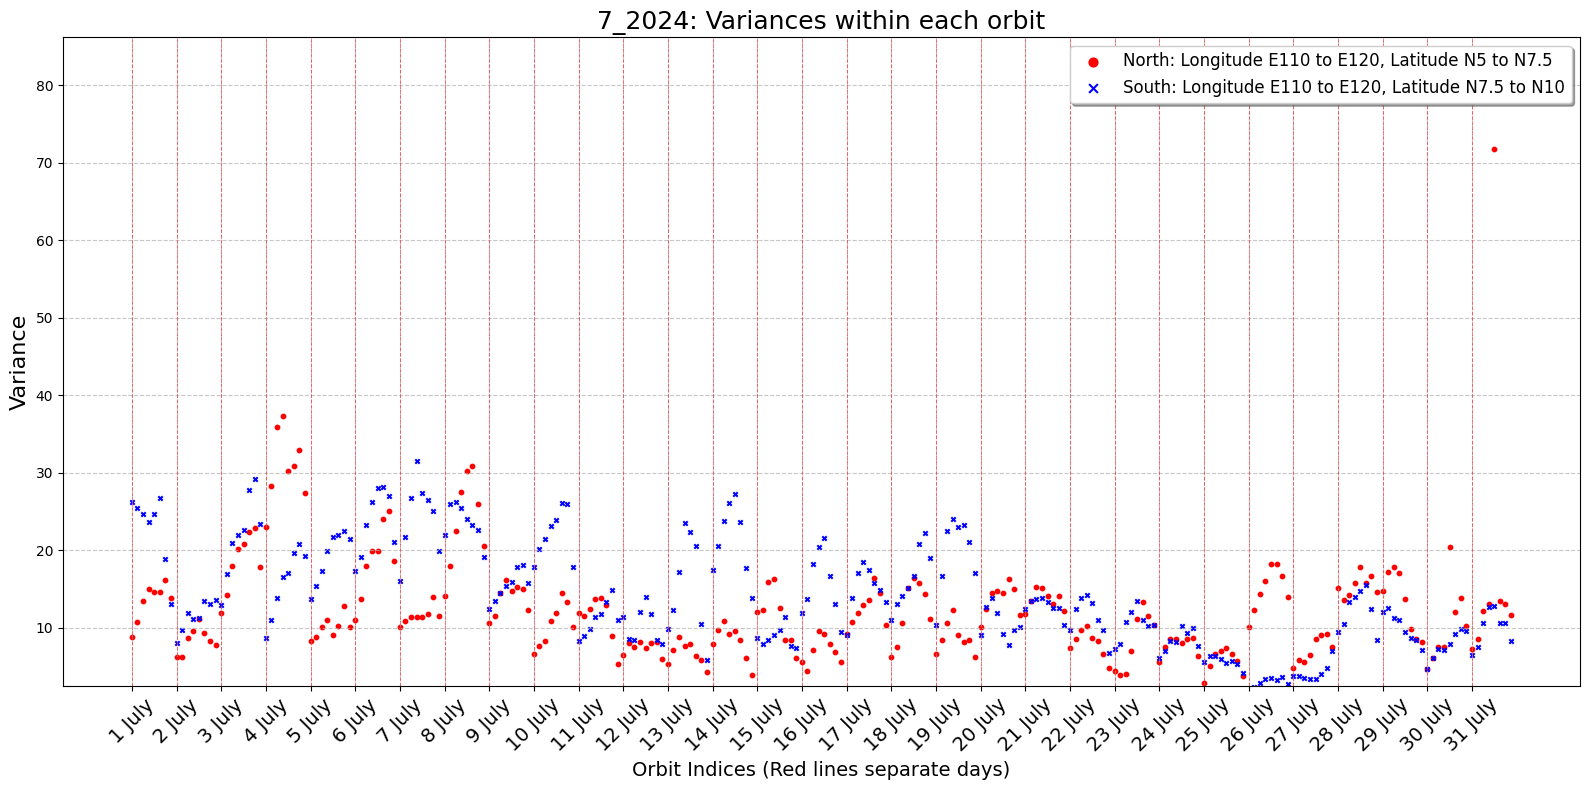

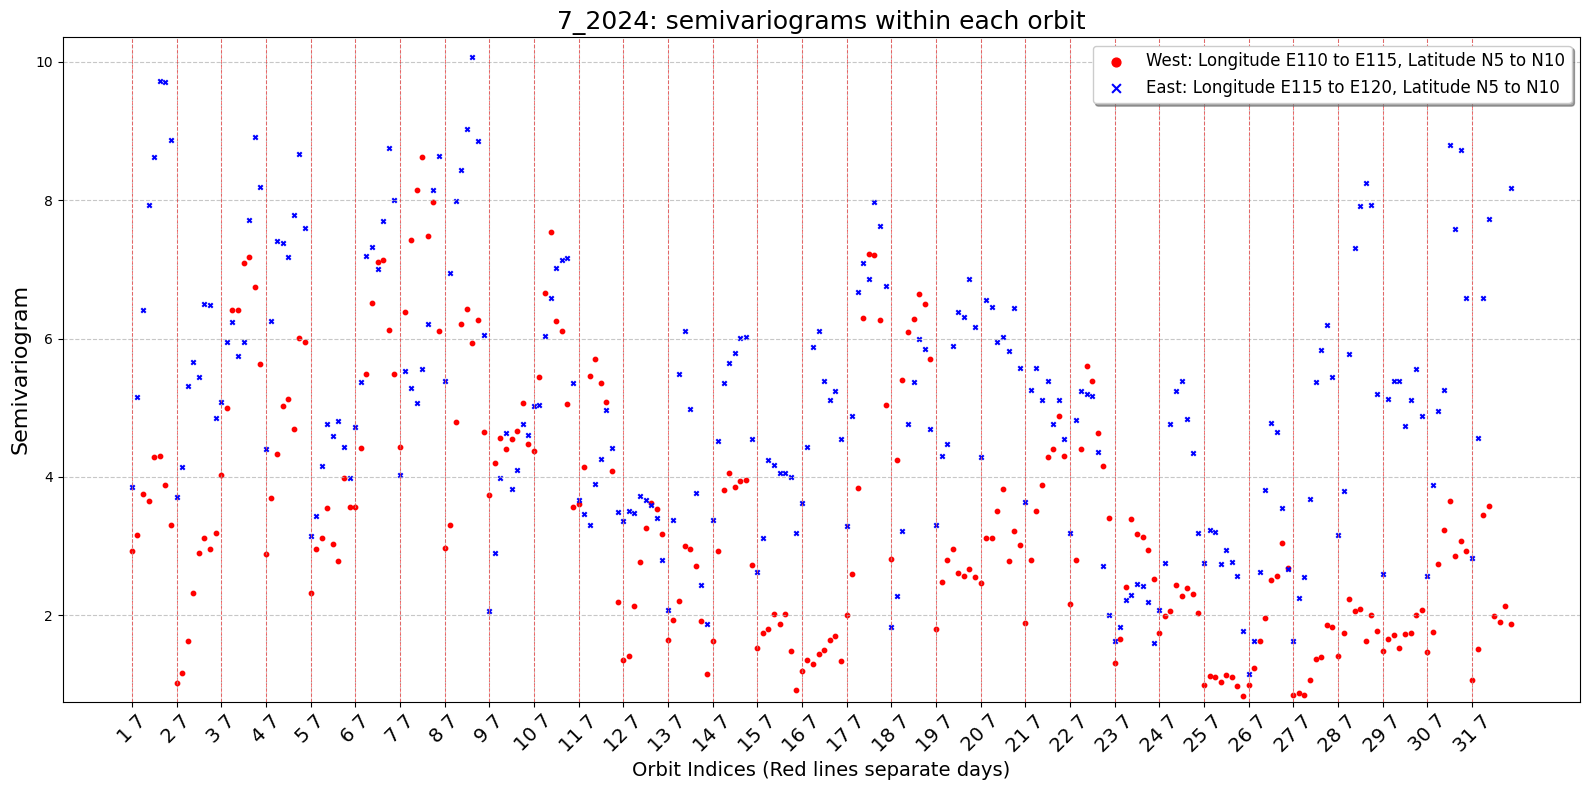

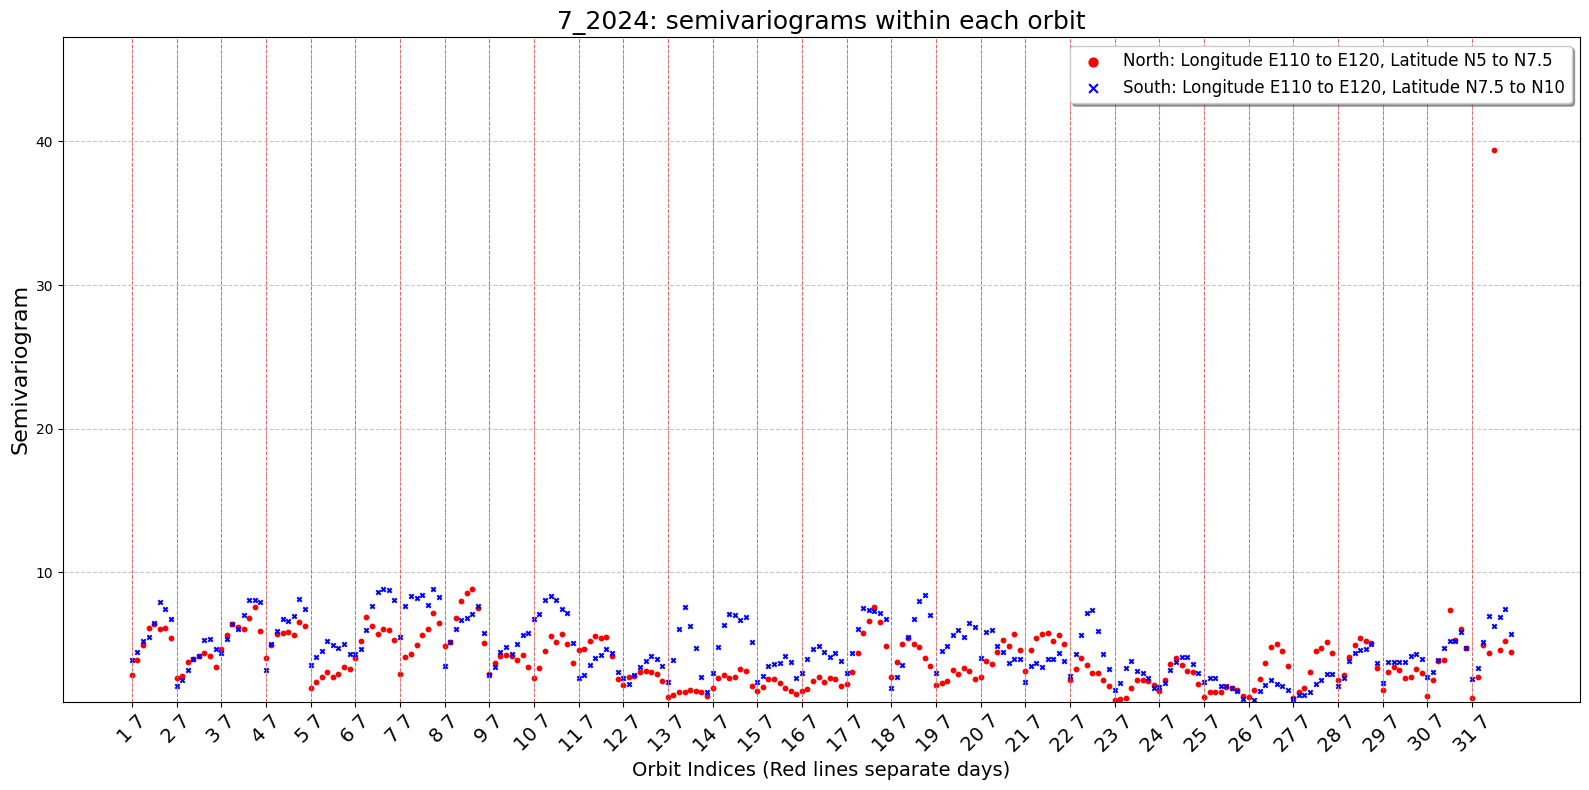

In [5]:
for year in ['2024']:
    for month in range(7,8):
        filepath = f"C:\\Users\\joonw\\TCO\\GEMS_data\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
        
        ''' 
        loaded_map should be a hash map that returns dataframe for 'year' and 'month'.
        '''

        instance_t = timeseries(loaded_map, year, month, output_dir)
        instance_t.save_data_plots()